In [1]:
import preprocessing_utils as p
import stgcn
import analysis as a
import speedband_dataset as d
import model_utils as m

from pathlib import Path
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np

# Settings

In [2]:
data_dir = Path("./data/processed")

# From training set
means = [4.03485028,  0.90566038,  0.05673374,  4.0460931 , 11.53766421]
stds = [1.02362099, 0.29230063, 0.03545753, 1.98377927, 6.93358581]

out_idx = 5
train_dataset = d.SpeedbandDataset(data_dir / "dataset" / "train", means, stds, out_idx = out_idx)
val_dataset = d.SpeedbandDataset(data_dir / "dataset" / "val", means, stds, out_idx = out_idx)
test_dataset = d.SpeedbandDataset(data_dir / "dataset" / "test", means, stds, out_idx = out_idx)
test_target_timestamps = np.load(data_dir / "dataset" / "test" / "output_timestamps.npy", allow_pickle=True)

A, metadata, cat2index, timestamps = p.load_metadata(data_dir)

num_timesteps_input = train_dataset.num_timesteps_input # 60 minutes
num_timesteps_output = train_dataset.num_timesteps_output # 1, since single output
num_features = train_dataset.num_features
num_nodes = train_dataset.num_nodes

model_path = "./saved_models/{}in{}out_single.pt".format(num_timesteps_input, out_idx + 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)

epochs = 500
batch_size = 32
lr = 0.001
patience = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

In [3]:
adj_mat = p.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).float()
adj_mat = adj_mat.to(device)

model = stgcn.STGCN(num_nodes, num_features, num_timesteps_input, num_timesteps_output)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = m.weighted_MSELoss(device=device)

# Training

Early stopping activated after epoch 17



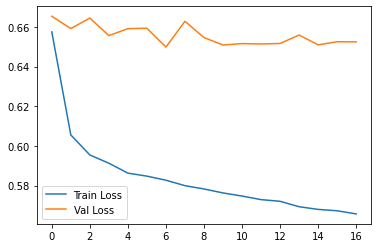

In [4]:
m.train(adj_mat, train_loader, val_loader, model, optimizer, criterion, patience, epochs, device)

In [5]:
m.save_model(model, model_path)

# Analysis

In [6]:
m.load_model(model, model_path)
m.validate(adj_mat, val_loader, model, criterion, device)

0.6498046254143497

In [7]:
pred, actual = m.predict(adj_mat, test_loader, model, means, stds, device)

In [8]:
rmses = a.rmse_per_link(pred, actual)
rmses = np.array(rmses)
timestep_rmses = []
best_roads = []
worst_roads = []
for i in range(rmses.shape[1]):
    best_roads.append(np.argmin(rmses[:, i]))
    worst_roads.append(np.argmax(rmses[:, i]))
    timestep_rmses.append(np.mean(rmses[:, i]))
timestep_rmses

[0.8133394009662125]

5 min worst road RMSE: 1.2643680572509766
Weekday (Thu)


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


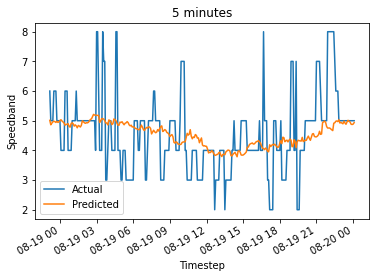

Weekend (Sat)


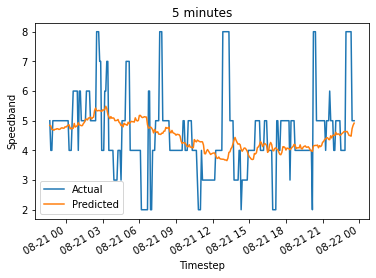

5 min best road RMSE: 0.4587768018245697
Weekday (Thu)


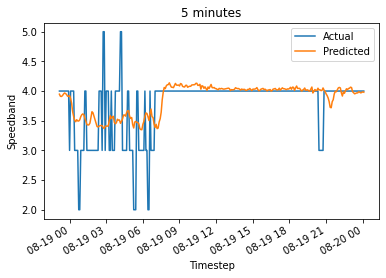

Weekend (Sat)


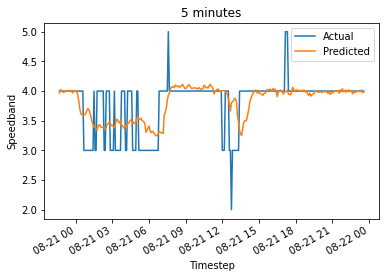

In [9]:
for i in range(len(timestep_rmses)):
    print("{} min worst road RMSE: {}".format((i+1)*5, rmses[worst_roads[i]][i]))
    print("Weekday (Thu)")
    a.plot_pred_actual(pred, actual, worst_roads[i], i, test_target_timestamps, (550, 850))
    print("Weekend (Sat)")
    a.plot_pred_actual(pred, actual, worst_roads[i], i, test_target_timestamps, (1120, 1420))
    print("{} min best road RMSE: {}".format((i+1)*5, rmses[best_roads[i]][i]))
    print("Weekday (Thu)")
    a.plot_pred_actual(pred, actual, best_roads[i], i, test_target_timestamps, (550, 850))
    print("Weekend (Sat)")
    a.plot_pred_actual(pred, actual, best_roads[i], i, test_target_timestamps, (1120, 1420))